Import libraries & Load data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set global style
plt.style.use('seaborn-v0_8')

# Path to data folder
DATA_DIR = Path("../data")

# Load datasets
order = pd.read_csv(DATA_DIR / "order_fact.csv")
courier = pd.read_csv(DATA_DIR / "courier_dim.csv", sep=";")  # Important: uses ";" delimiter
customer = pd.read_csv(DATA_DIR / "customer_dim.csv")
location = pd.read_csv(DATA_DIR / "location_dim.csv")

print("Shapes:")
print("Order:", order.shape)
print("Courier:", courier.shape)
print("Customer:", customer.shape)
print("Location:", location.shape)

order.head()


Shapes:
Order: (5492, 22)
Courier: (68, 4)
Customer: (107, 3)
Location: (509, 4)


,id,awbnumber,creationdate,activedate,consigner_id,consignee_name,package_price_value,package_weight_value,package_cubicalweight_value,package_finalweight_value,...,destination_cityid,destination_provinceid,courier_rate_id,courier_id,rates_shipment_value,rates_insurance_value,surchargefee,partition_date,delivery_sla,adj_pick_up_sla
0,54d0f909,7e64d444,2025-07-06 12:52:03.000000 UTC,2025-07-06 12:54:02.000000 UTC,64e5a743042497bc227dd2c0,Rocky Balboa,267900.0,3.43,1.220000,4.0,...,357,28,1,1,68000.0,0.0,0.0,2025-07-06,Out of SLA,Out-SLA
1,40224e36,b210fe95,2025-07-06 12:40:03.000000 UTC,2025-07-06 12:42:02.000000 UTC,64e5a743042497bc227dd2c0,Leia Organa,974700.0,4.30,4.368000,5.0,...,475,34,312,1,75000.0,2437.0,0.0,2025-07-06,In SLA,In-SLA
2,5dc5095f,62a22ee4,2025-07-06 11:48:02.000000 UTC,2025-07-06 11:50:03.000000 UTC,64e5a743042497bc227dd2c0,Jeboy,60000.0,0.20,0.273675,1.0,...,187,15,1,1,25000.0,0.0,0.0,2025-07-06,In SLA,In-SLA
3,4c8e2bbb,e3b0c442,2025-07-06 13:04:56.000000 UTC,NaN,64ec46a8b880275fdf863e48,Han Solo,27500.0,0.10,0.152112,1.0,...,478,9,1,1,12000.0,0.0,0.0,2025-07-06,Out of SLA,Order Not Activated
4,84d5ce1c,d6dff3aa,2025-07-06 13:02:02.000000 UTC,2025-07-06 13:04:01.000000 UTC,64e5a743042497bc227dd2c0,Harry Potter,99950.0,1.20,2.068000,2.0,...,22,3,4,1,20000.0,0.0,0.0,2025-07-06,In SLA,In-SLA


Check columns & missing values

In [10]:
for name, df_tmp in {
    "order": order,
    "courier": courier,
    "customer": customer,
    "location": location
}.items():
    print(f"\n{name.upper()} COLUMNS:\n", df_tmp.columns.tolist())
    print("Missing values:\n", df_tmp.isnull().sum())



ORDER COLUMNS:
 ['id', 'awbnumber', 'creationdate', 'activedate', 'consigner_id', 'consignee_name', 'package_price_value', 'package_weight_value', 'package_cubicalweight_value', 'package_finalweight_value', 'origin_cityid', 'origin_provinceid', 'destination_cityid', 'destination_provinceid', 'courier_rate_id', 'courier_id', 'rates_shipment_value', 'rates_insurance_value', 'surchargefee', 'partition_date', 'delivery_sla', 'adj_pick_up_sla']
Missing values:
 id                               0
awbnumber                        0
creationdate                     0
activedate                     525
consigner_id                     0
consignee_name                   0
package_price_value              0
package_weight_value             0
package_cubicalweight_value      0
package_finalweight_value        0
origin_cityid                    0
origin_provinceid                0
destination_cityid               0
destination_provinceid           0
courier_rate_id                  0
courier_id   

Merge datasets


In [11]:
# Merge order + courier
df = order.merge(courier, left_on='courier_rate_id', right_on='rate_id', how='left')

# Merge province
if 'destination_provinceid' in df.columns and 'province_id' in location.columns:
    df = df.merge(location[['province_id','province_name']].drop_duplicates(),
                  left_on='destination_provinceid', right_on='province_id', how='left')

# Merge city
if 'destination_cityid' in df.columns and 'city_id' in location.columns:
    df = df.merge(location[['city_id','city_name']].drop_duplicates(),
                  left_on='destination_cityid', right_on='city_id', how='left')

# Merge customer
cust_left_key = 'customer_id' if 'customer_id' in order.columns else (
    'customer_companyid' if 'customer_companyid' in order.columns else None
)
cust_right_key = 'customer_id' if 'customer_id' in customer.columns else (
    'company_id' if 'company_id' in customer.columns else None
)
if cust_left_key and cust_right_key:
    df = df.merge(customer, left_on=cust_left_key, right_on=cust_right_key, how='left')

print("Final merged shape:", df.shape)
df.head()


Final merged shape: (5492, 30)


,id,awbnumber,creationdate,activedate,consigner_id,consignee_name,package_price_value,package_weight_value,package_cubicalweight_value,package_finalweight_value,...,delivery_sla,adj_pick_up_sla,rate_id,logistic_id,service_name,logistic_name,province_id,province_name,city_id,city_name
0,54d0f909,7e64d444,2025-07-06 12:52:03.000000 UTC,2025-07-06 12:54:02.000000 UTC,64e5a743042497bc227dd2c0,Rocky Balboa,267900.0,3.43,1.220000,4.0,...,Out of SLA,Out-SLA,1.0,1.0,Standard,Veridian,28.0,Sulawesi Selatan,357.0,Takalar
1,40224e36,b210fe95,2025-07-06 12:40:03.000000 UTC,2025-07-06 12:42:02.000000 UTC,64e5a743042497bc227dd2c0,Leia Organa,974700.0,4.30,4.368000,5.0,...,In SLA,In-SLA,312.0,1.0,Freight,Veridian,34.0,Sumatera Utara,475.0,Medan
2,5dc5095f,62a22ee4,2025-07-06 11:48:02.000000 UTC,2025-07-06 11:50:03.000000 UTC,64e5a743042497bc227dd2c0,Jeboy,60000.0,0.20,0.273675,1.0,...,In SLA,In-SLA,1.0,1.0,Standard,Veridian,15.0,Kalimantan Timur,187.0,Balikpapan
3,4c8e2bbb,e3b0c442,2025-07-06 13:04:56.000000 UTC,NaN,64ec46a8b880275fdf863e48,Han Solo,27500.0,0.10,0.152112,1.0,...,Out of SLA,Order Not Activated,1.0,1.0,Standard,Veridian,9.0,Jawa Barat,478.0,"Bandung, Kota"
4,84d5ce1c,d6dff3aa,2025-07-06 13:02:02.000000 UTC,2025-07-06 13:04:01.000000 UTC,64e5a743042497bc227dd2c0,Harry Potter,99950.0,1.20,2.068000,2.0,...,In SLA,In-SLA,4.0,1.0,Connect,Veridian,3.0,Banten,22.0,Tangerang Selatan


Feature engineering

In [12]:
# Parse datetime columns
ts_cols = ['creationdate','accepteddate','delivereddate','laststatusdate']
for c in ts_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Delivery duration (minutes)
if set(['creationdate','delivereddate']).issubset(df.columns):
    df['delivery_minutes'] = (df['delivereddate'] - df['creationdate']).dt.total_seconds() / 60.0

# Binary target: 1 = In SLA, 0 = Out of SLA
if 'delivery_sla' in df.columns:
    df['delivery_sla_binary'] = df['delivery_sla'].astype(str).str.lower().str.contains('in').astype(int)

df[['delivery_sla','delivery_sla_binary']].head()


,delivery_sla,delivery_sla_binary
0,Out of SLA,0
1,In SLA,1
2,In SLA,1
3,Out of SLA,0
4,In SLA,1


EDA Visuals (with Insights & Recommendations)

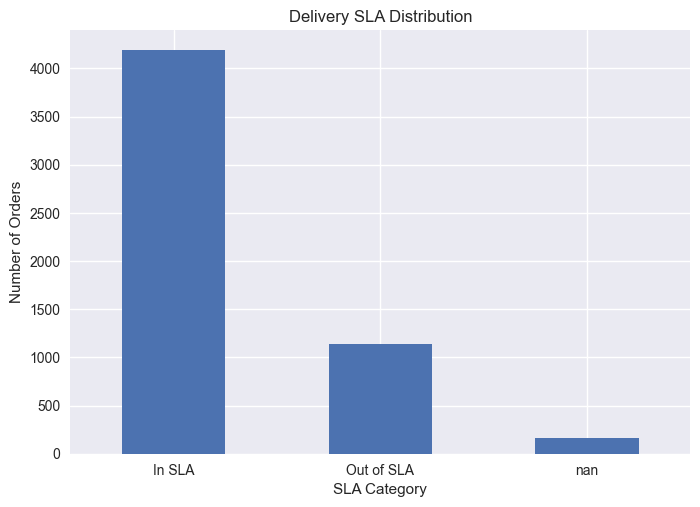

In [13]:
df['delivery_sla'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.title('Delivery SLA Distribution')
plt.xlabel('SLA Category')
plt.ylabel('Number of Orders')
plt.show()


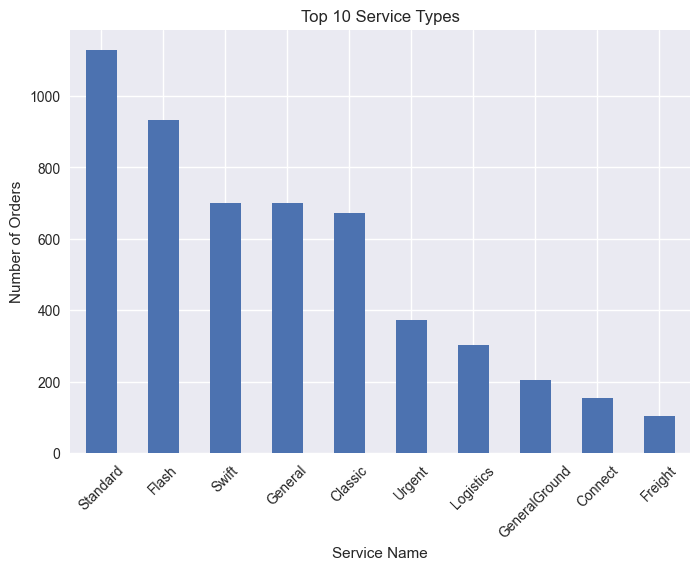

In [14]:
df['service_name'].value_counts().head(10).plot(kind='bar', rot=45)
plt.title('Top 10 Service Types')
plt.xlabel('Service Name')
plt.ylabel('Number of Orders')
plt.show()


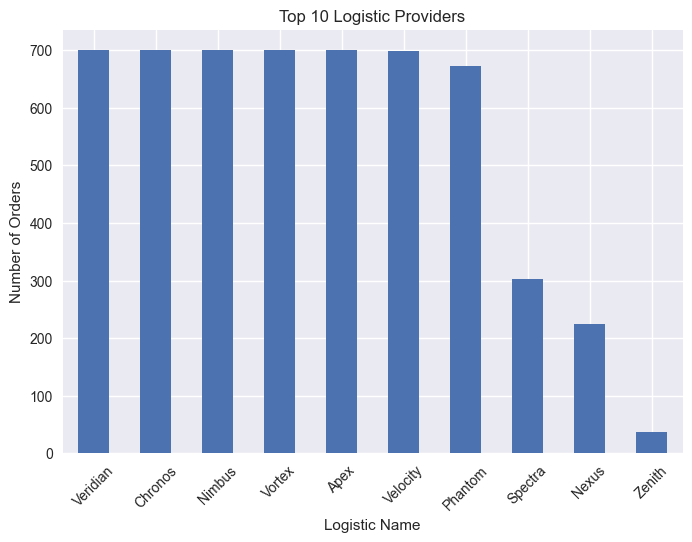

In [15]:
df['logistic_name'].value_counts().head(10).plot(kind='bar', rot=45)
plt.title('Top 10 Logistic Providers')
plt.xlabel('Logistic Name')
plt.ylabel('Number of Orders')
plt.show()


Save features for modeling

In [16]:
# Numeric and categorical features
num_cols = [
    'package_finalweight_value','rates_shipment_value',
    'rates_insurance_value','surchargefee','delivery_minutes'
]
cat_cols = ['service_name','logistic_name','province_name','city_name']

# Keep only existing columns
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

# Final feature set
features = df[cat_cols + num_cols + ['delivery_sla_binary']].copy()
features.to_csv("../data/features_for_model.csv", index=False)

print("✅ Features saved to ../data/features_for_model.csv")
features.head()


✅ Features saved to ../data/features_for_model.csv


,service_name,logistic_name,province_name,city_name,package_finalweight_value,rates_shipment_value,rates_insurance_value,surchargefee,delivery_sla_binary
0,Standard,Veridian,Sulawesi Selatan,Takalar,4.0,68000.0,0.0,0.0,0
1,Freight,Veridian,Sumatera Utara,Medan,5.0,75000.0,2437.0,0.0,1
2,Standard,Veridian,Kalimantan Timur,Balikpapan,1.0,25000.0,0.0,0.0,1
3,Standard,Veridian,Jawa Barat,"Bandung, Kota",1.0,12000.0,0.0,0.0,0
4,Connect,Veridian,Banten,Tangerang Selatan,2.0,20000.0,0.0,0.0,1
